In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
%config IPCompleter.greedy=True
%config IPCompleter.use_jedi=False
%config Completer.use_jedi = False

In [3]:
# for tab autocompletion

# !pip install jupyter-tabnine
# !pip install ucimlrepo

<h3> Binary Classification - Heart Disease dataset </h3>

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler 
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score,roc_curve,accuracy_score, precision_score, recall_score, f1_score
from sklearn.linear_model import LogisticRegression
from sklearn.impute import SimpleImputer

from ucimlrepo import fetch_ucirepo 
sns.set(style= "whitegrid")

<h3> Dataset column description </h3>

Feature Name | Actual Description

age | Age of the patient (in years)

sex | Sex (1 = male; 0 = female)

cp | Chest pain type (0–3 categories)

trestbps | Resting blood pressure (in mm Hg)

chol | Serum cholesterol level (in mg/dl)

fbs | Fasting blood sugar > 120 mg/dl (1 = true; 0 = false)

restecg | Resting electrocardiographic results (0–2 categories)

thalach | Maximum heart rate achieved

exang | Exercise induced angina (1 = yes; 0 = no)

oldpeak | ST depression induced by exercise relative to rest

slope | Slope of the peak exercise ST segment (0–2 categories)

ca | Number of major vessels (0–3) colored by fluoroscopy

thal | Thalassemia (1 = normal; 2 = fixed defect; 3 = reversible defect)

In [5]:
# Fetch Dataset
heart_disease = fetch_ucirepo(id=45)

# Features and Target
X = heart_disease.data.features
y = heart_disease.data.targets

print("Features shape:", X.shape)
print("Targets shape:", y.shape)

# See target variable
print("\nTarget 'num' unique values:\n", y['num'].value_counts())

Features shape: (303, 13)
Targets shape: (303, 1)

Target 'num' unique values:
 num
0    164
1     55
2     36
3     35
4     13
Name: count, dtype: int64


num value | Meaning

0 | No heart disease (healthy)

1, 2, 3, 4 | Different levels of heart disease severity

In [6]:
X.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal
0,63,1,1,145,233,1,2,150,0,2.3,3,0.0,6.0
1,67,1,4,160,286,0,2,108,1,1.5,2,3.0,3.0
2,67,1,4,120,229,0,2,129,1,2.6,2,2.0,7.0
3,37,1,3,130,250,0,0,187,0,3.5,3,0.0,3.0
4,41,0,2,130,204,0,2,172,0,1.4,1,0.0,3.0


In [7]:
# Check Missing Values
print(X.isnull().sum())

age         0
sex         0
cp          0
trestbps    0
chol        0
fbs         0
restecg     0
thalach     0
exang       0
oldpeak     0
slope       0
ca          4
thal        2
dtype: int64


<h3>Step 2: Convert target to binary </h3>

In [8]:
target_col = 'num'
#convert 0 -> 0 (no disease), 1-4 -> (has disease)

y_binary = y.copy()
y_binary[target_col] = y_binary[target_col].apply(lambda x: 1 if x > 0 else 0)

In [9]:
#check distribution 
print("\n Binary Target Distribution\n", y_binary.value_counts())


 Binary Target Distribution
 num
0      164
1      139
Name: count, dtype: int64


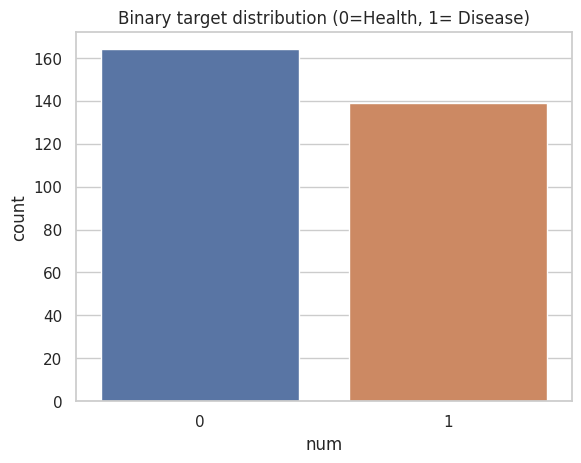

In [10]:
sns.countplot(x=y_binary[target_col])
plt.title('Binary target distribution (0=Health, 1= Disease)')
plt.show()

<h3> Step 3: EDA </h3>

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 303 entries, 0 to 302
Data columns (total 13 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       303 non-null    int64  
 1   sex       303 non-null    int64  
 2   cp        303 non-null    int64  
 3   trestbps  303 non-null    int64  
 4   chol      303 non-null    int64  
 5   fbs       303 non-null    int64  
 6   restecg   303 non-null    int64  
 7   thalach   303 non-null    int64  
 8   exang     303 non-null    int64  
 9   oldpeak   303 non-null    float64
 10  slope     303 non-null    int64  
 11  ca        299 non-null    float64
 12  thal      301 non-null    float64
dtypes: float64(3), int64(10)
memory usage: 30.9 KB
None
              age         sex          cp    trestbps        chol         fbs  \
count  303.000000  303.000000  303.000000  303.000000  303.000000  303.000000   
mean    54.438944    0.679868    3.158416  131.689769  246.693069    0.148515   
std      9

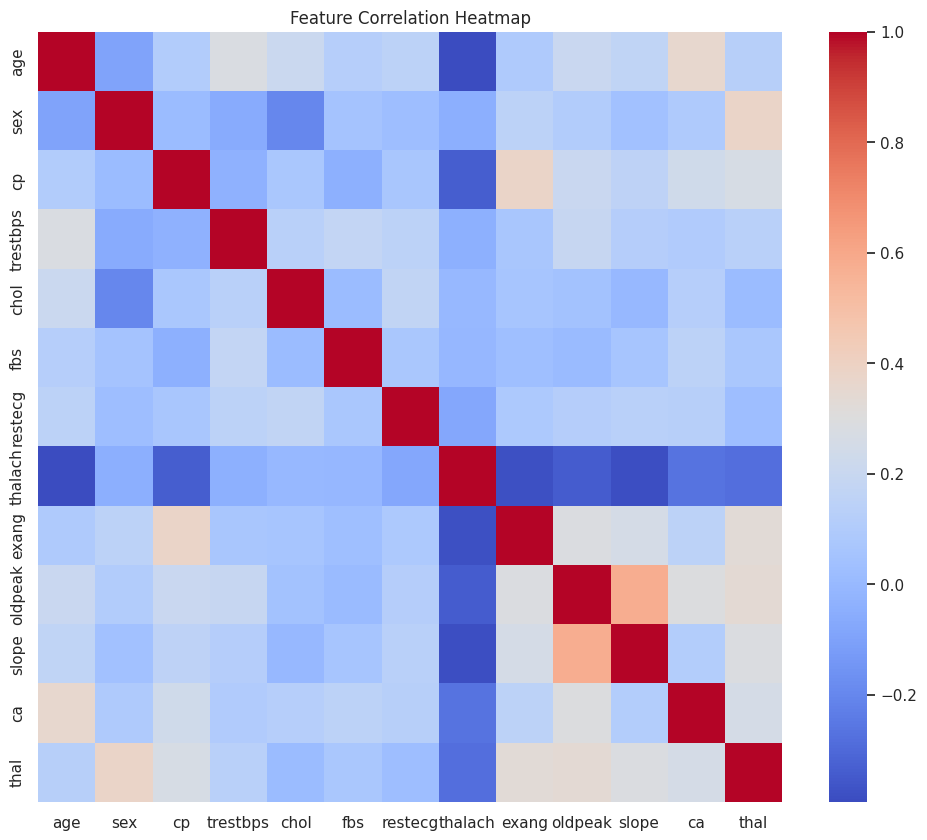

In [11]:
#check info

print(X.info())
print(X.describe())

#check missing values 
print('\nMissing values:\n', X.isnull().sum())

#Correlation Heatmap

plt.figure(figsize =(12,10))

sns.heatmap(X.corr(), cmap = 'coolwarm', annot=False)
plt.title("Feature Correlation Heatmap")
plt.show()

In [12]:
imputer = SimpleImputer(strategy='median')
X_imputed = pd.DataFrame(imputer.fit_transform(X), columns=X.columns)

# Use X_imputed values from here onwards

X = X_imputed.values #convert to numpy arrays


<h3>Step 4: Train-Test Split + Scaling </h3>

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X, y_binary[target_col],test_size = 0.2, random_state=42, stratify=y_binary[target_col])

#scale the features

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled =  scaler.transform(X_test)

<h3>Step 5: Train Logistic Regression</h3>

In [14]:
#built the model

logreg = LogisticRegression(max_iter = 1000, random_state =42)
logreg.fit(X_train_scaled, y_train)

LogisticRegression(max_iter=1000, random_state=42)

In [15]:
#predict
y_pred = logreg.predict(X_test_scaled)

print(y_pred)

[0 1 0 0 1 0 0 0 1 0 1 0 0 1 1 1 1 0 1 1 1 0 1 1 1 0 0 1 0 1 0 1 1 0 0 1 0
 0 0 1 1 1 1 1 0 0 1 0 1 0 0 1 1 0 0 1 1 1 0 0 1]


In [16]:
# Evaluation
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred))
print("Recall:", recall_score(y_test, y_pred))
print("F1 Score:", f1_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

Accuracy: 0.8688524590163934
Precision: 0.8125
Recall: 0.9285714285714286
F1 Score: 0.8666666666666666

Classification Report:
               precision    recall  f1-score   support

           0       0.93      0.82      0.87        33
           1       0.81      0.93      0.87        28

    accuracy                           0.87        61
   macro avg       0.87      0.87      0.87        61
weighted avg       0.88      0.87      0.87        61



In [17]:
y_pred_prob = logreg.predict_proba(X_test_scaled)[:,1]
y_pred_prob

array([0.21774708, 0.70829097, 0.05823558, 0.03688628, 0.53637761,
       0.02417327, 0.11945793, 0.22025792, 0.80884941, 0.31342537,
       0.87267245, 0.01374502, 0.09241929, 0.98955812, 0.89692245,
       0.97936411, 0.91311432, 0.30595175, 0.8572964 , 0.94455233,
       0.60948907, 0.10919313, 0.72084562, 0.78130415, 0.72478472,
       0.06793081, 0.12273785, 0.97935462, 0.33163438, 0.90723445,
       0.36361474, 0.95104135, 0.84560994, 0.34372721, 0.16534891,
       0.93706978, 0.27994264, 0.31634485, 0.1008346 , 0.75769647,
       0.98072522, 0.99746342, 0.98034018, 0.91765796, 0.07767694,
       0.07249015, 0.85935317, 0.03935881, 0.99800459, 0.33716664,
       0.0410006 , 0.97009082, 0.6809484 , 0.18543792, 0.3603423 ,
       0.94656215, 0.99588831, 0.59302063, 0.03665187, 0.02649344,
       0.98852347])

<h3>Step 6: Evaluation </h3>

In [18]:
# Classification Report
print("\nClassification Report:\n", classification_report(y_test, y_pred))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
print("\nConfusion Matrix:\n", cm)

# ROC AUC
roc_auc = roc_auc_score(y_test, y_pred_prob)
print("\nROC AUC Score:", roc_auc)



Classification Report:
               precision    recall  f1-score   support

           0       0.93      0.82      0.87        33
           1       0.81      0.93      0.87        28

    accuracy                           0.87        61
   macro avg       0.87      0.87      0.87        61
weighted avg       0.88      0.87      0.87        61


Confusion Matrix:
 [[27  6]
 [ 2 26]]

ROC AUC Score: 0.9512987012987013


<h3>Step 7: Plot Confusion Matrix + ROC Curve </h3>

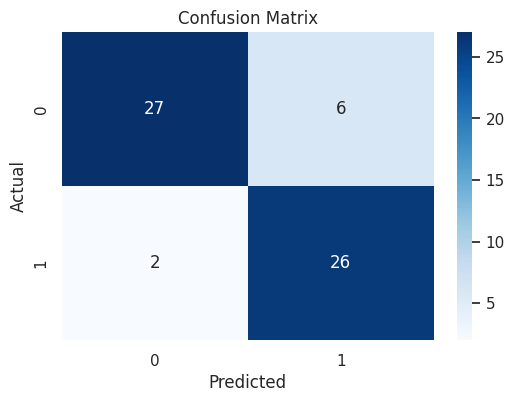

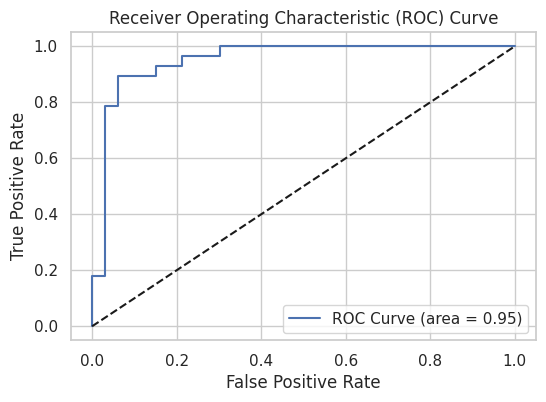

In [19]:
# Confusion Matrix Heatmap
plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
plt.figure(figsize=(6,4))
plt.plot(fpr, tpr, label="ROC Curve (area = {:.2f})".format(roc_auc))
plt.plot([0,1],[0,1],'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver Operating Characteristic (ROC) Curve")
plt.legend()
plt.show()


<h3>Multiclass Logistic Regression Code </h3>

<h3> Step 1: Load dataset </h3>

Features shape: (303, 13)
Target shape: (303, 1)

Original Target Value Counts:
 num
0    164
1     55
2     36
3     35
4     13
Name: count, dtype: int64


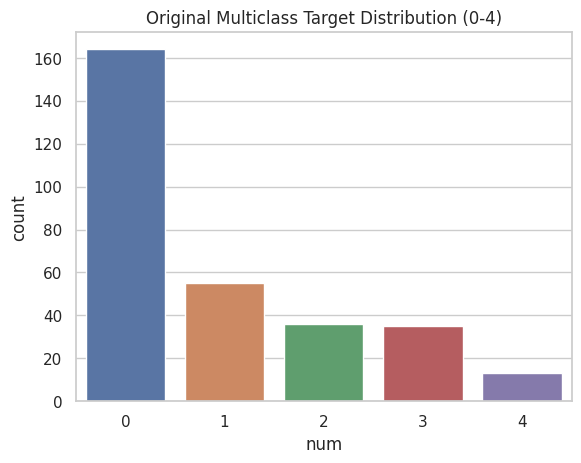

In [20]:
# Fetch Dataset
heart_disease = fetch_ucirepo(id=45)

# Features and Target
X = heart_disease.data.features
y = heart_disease.data.targets

# Target Column
target_col = 'num'

# Print shapes
print("Features shape:", X.shape)
print("Target shape:", y.shape)

# View Target Distribution
print("\nOriginal Target Value Counts:\n", y[target_col].value_counts())
sns.countplot(x=y[target_col])
plt.title("Original Multiclass Target Distribution (0-4)")
plt.show()

<h2>Step 2: EDA + Missing Value Handling </h3>

In [21]:
#check info

print(X.info())
print(X.describe())

# Missing value check 

print("\nMissig Values:\n", X.isnull().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 303 entries, 0 to 302
Data columns (total 13 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       303 non-null    int64  
 1   sex       303 non-null    int64  
 2   cp        303 non-null    int64  
 3   trestbps  303 non-null    int64  
 4   chol      303 non-null    int64  
 5   fbs       303 non-null    int64  
 6   restecg   303 non-null    int64  
 7   thalach   303 non-null    int64  
 8   exang     303 non-null    int64  
 9   oldpeak   303 non-null    float64
 10  slope     303 non-null    int64  
 11  ca        299 non-null    float64
 12  thal      301 non-null    float64
dtypes: float64(3), int64(10)
memory usage: 30.9 KB
None
              age         sex          cp    trestbps        chol         fbs  \
count  303.000000  303.000000  303.000000  303.000000  303.000000  303.000000   
mean    54.438944    0.679868    3.158416  131.689769  246.693069    0.148515   
std      9

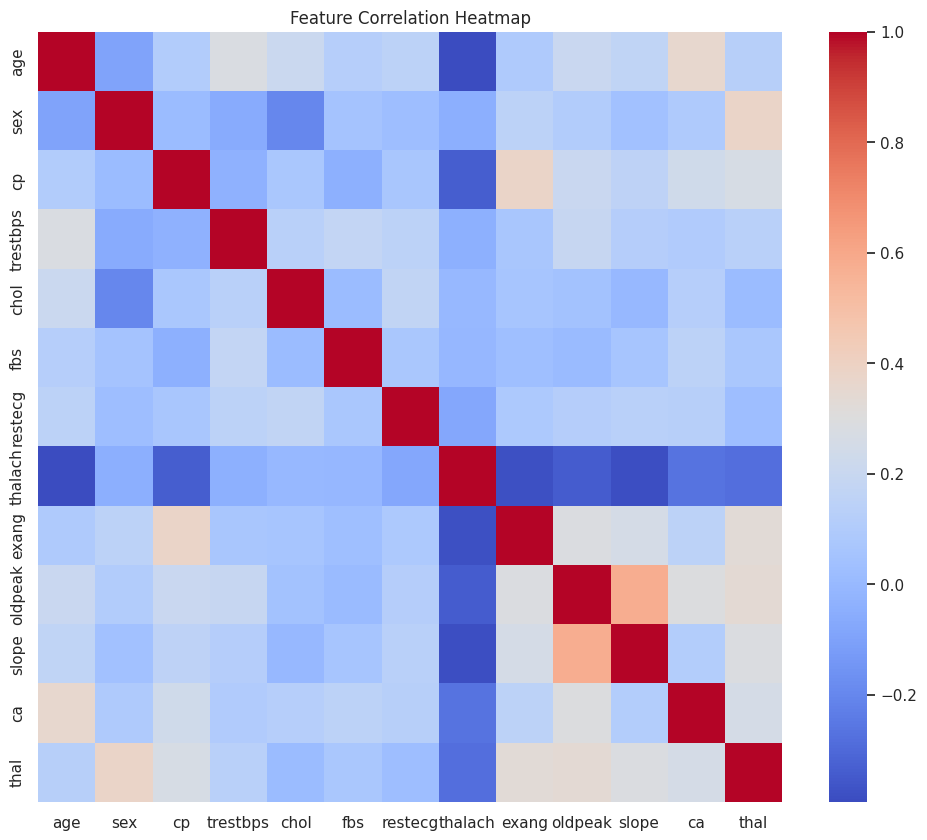

In [22]:
#correlation heatmap
plt.figure(figsize=(12,10))
sns.heatmap(X.corr(), cmap= 'coolwarm', annot=False)
plt.title("Feature Correlation Heatmap")
plt.show()

In [23]:
#Handle missing values

imputer = SimpleImputer(strategy='median')
X_imputed = pd.DataFrame(imputer.fit_transform(X), columns = X.columns)

<h3>Step 3: Prepare Data for Modeling </h3>

In [24]:
# After EDA, convert to NumPy

X = X_imputed.values
y = y[target_col].values #convert target to numpy as well

# Train-Test split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=42, stratify = y)


In [25]:
#scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

<h3> Step 4: Train Multiclass Logistic Regression </h3>

In [26]:
## Multiclass Logistic Regression

logreg_multi = LogisticRegression(multi_class= 'multinomial', solver='lbfgs', max_iter=1000, random_state=42) 

# solver is optimization algorithm is used to find the best model parameters (weights) during training. Limited-memory BFGS (quasi-Newton method)
# Basically, solvers are different mathematical techniques for minimizing the loss function.

In [27]:
logreg_multi.fit(X_train_scaled, y_train)

# Predict
y_pred_multi = logreg_multi.predict(X_test_scaled)

In [28]:
# Evaluation
print("Accuracy:", accuracy_score(y_test, y_pred_multi))
print("Macro Precision:", precision_score(y_test, y_pred_multi, average='macro'))
print("Macro Recall:", recall_score(y_test, y_pred_multi, average='macro'))
print("Macro F1 Score:", f1_score(y_test, y_pred_multi, average='macro'))
print("\nClassification Report:\n", classification_report(y_test, y_pred_multi))

Accuracy: 0.6065573770491803
Macro Precision: 0.35519831519831524
Macro Recall: 0.36277056277056274
Macro F1 Score: 0.35748917748917747

Classification Report:
               precision    recall  f1-score   support

           0       0.78      0.88      0.83        33
           1       0.36      0.36      0.36        11
           2       0.20      0.14      0.17         7
           3       0.43      0.43      0.43         7
           4       0.00      0.00      0.00         3

    accuracy                           0.61        61
   macro avg       0.36      0.36      0.36        61
weighted avg       0.56      0.61      0.58        61



<h3>Step 5: Evaluate Multiclass Model </h3>


Classification Report:
               precision    recall  f1-score   support

           0       0.78      0.88      0.83        33
           1       0.36      0.36      0.36        11
           2       0.20      0.14      0.17         7
           3       0.43      0.43      0.43         7
           4       0.00      0.00      0.00         3

    accuracy                           0.61        61
   macro avg       0.36      0.36      0.36        61
weighted avg       0.56      0.61      0.58        61


Confusion Matrix:
 [[29  3  1  0  0]
 [ 6  4  1  0  0]
 [ 2  1  1  3  0]
 [ 0  1  2  3  1]
 [ 0  2  0  1  0]]


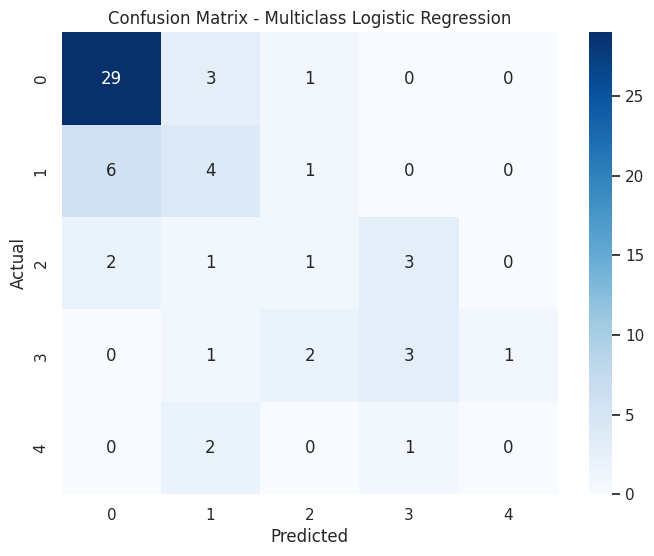

In [29]:
# Classification Report
print("\nClassification Report:\n", classification_report(y_test, y_pred_multi))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred_multi)
print("\nConfusion Matrix:\n", cm)

# Plot Confusion Matrix
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix - Multiclass Logistic Regression")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


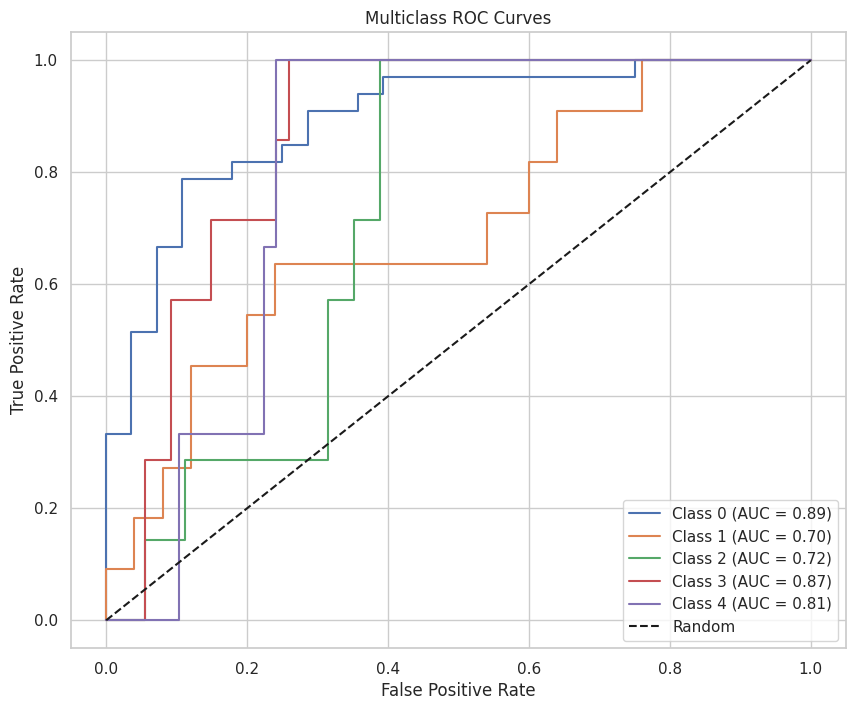

Macro-average ROC-AUC: 0.7981


In [30]:
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt

# Assuming y_test and y_pred_proba

# Binarize the output for ROC (One-vs-Rest)
y_test_bin = label_binarize(y_test, classes=[0,1,2,3,4])
y_score_bin = logreg_multi.predict_proba(X_test_scaled)

# Compute ROC curve and AUC for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
n_classes = y_test_bin.shape[1]

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_score_bin[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot all ROC curves
plt.figure(figsize=(10,8))
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label=f"Class {i} (AUC = {roc_auc[i]:.2f})")

plt.plot([0,1], [0,1], 'k--', label="Random")
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Multiclass ROC Curves')
plt.legend()
plt.show()

# Macro-average AUC score
macro_roc_auc_ovr = roc_auc_score(y_test_bin, y_score_bin, average="macro")
print(f"Macro-average ROC-AUC: {macro_roc_auc_ovr:.4f}")
